### Illustration of Mutal Information

Requires to install (via pip) the `nilearn` and the `nibabel` package.

In [1]:
import nilearn
import nibabel as nib

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

nilearn.datasets.fetch_icbm152_2009(data_dir='./data', verbose=0)

{'description': b'ICBM 152 Atlas\r\n\r\n\r\nNotes\r\n-----\r\nReferences atlases intended for spatial normalization, registration, and\r\nsegmentation of MRI data. These atlases were generated from large ensembles\r\nof MRI data in an unbiased fashion. MRI data from templates are derived from\r\n"a truly normal, well characterized population."\r\n\r\n\r\nContent\r\n-------\r\n    :\'csf\': probabilistic map for cerebrospinal fluid\r\n    :\'gm\': probabilistic map for gray matter\r\n    :\'wm\': probabilistic map for white matter\r\n    :\'pd\': proton density-weighted anatomical templates (non-linear average)\r\n    :\'t1\': T1-weighted anatomical template (non-linear average)\r\n    :\'t2\': T2-weighted anatomical template (non-linear average)\r\n    :\'t2_relax\': T2-weighted/relaxed anatomical template\r\n    :\'eye_mask\': average mask for eyes\r\n    :\'face_mask\': average mask for face\r\n    :\'mask\': average mask for brain\r\n\r\n\r\nReferences\r\n----------\r\nFor more info

In [2]:
t1_file = './data/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii.gz'
t2_file = './data/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_t2_tal_nlin_sym_09a.nii.gz'

t1_img = nib.load(t1_file)
t1_data = t1_img.get_fdata()
t2_img = nib.load(t2_file)
t2_data = t2_img.get_fdata()

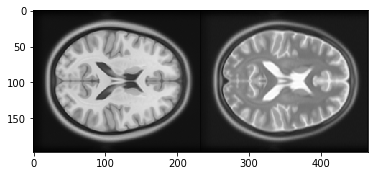

In [3]:
t1_slice = t1_data[:,:,90]
t2_slice = t2_data[:,:,90]

plt.rcParams['image.cmap'] = 'gray'
plt.imshow(np.hstack((t1_slice,t2_slice)))

Let's compute **SSD** first:

In [4]:
ssd = 1.0/np.prod(t1_slice.shape) * np.sum(np.power((t1_slice-t2_slice).ravel(),2.0))
print(ssd)
print(t1_slice.shape)

374.54367373284356
(197, 233)


Visualize the per-image intensity histograms:

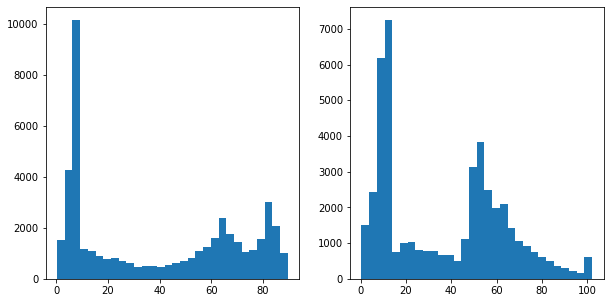

In [5]:
fig = plt.figure(figsize=(10,5))
axes = fig.subplots(1,2)
axes[0].hist(t1_slice.ravel(), bins=30);
axes[1].hist(t2_slice.ravel(), bins=30);

Lets plot the vectorized versions of both images against each other ...

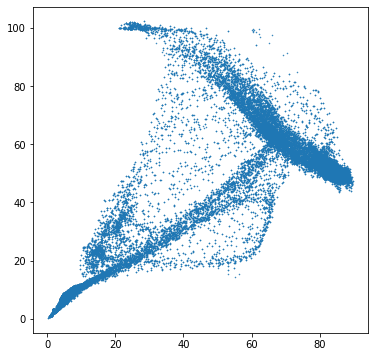

In [6]:
fig = plt.figure(figsize=(6,6))
plt.plot(t1_slice.ravel(),t2_slice.ravel(),'.', markersize=1)

Compute 2D historam with 50 bins:

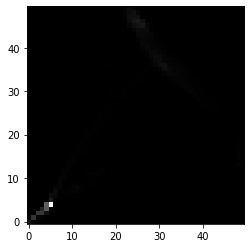

In [7]:
hist_2d,edges_x,edges_Y = np.histogram2d(t1_slice.ravel(),t2_slice.ravel(),bins=50)
plt.imshow(hist_2d, origin='lower')

Since this is not really informative, compute the log:

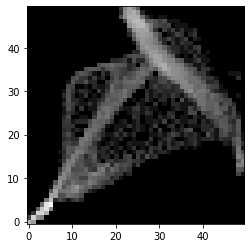

In [8]:
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log, origin='lower')

Implement **mutal information** computation based on the 2D histogram:

In [9]:
def mutual_information(hgram):
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [10]:
print('MI (T1 vs T2 aligned):', mutual_information(hist_2d))

MI (T1 vs T2 aligned): 1.7279573636373788


Artificially shift (translate) the T2 image:

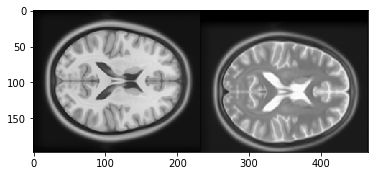

In [11]:
t2_slice_moved = np.zeros(t2_slice.shape)
t2_slice_moved[15:,:] = t2_slice[:-15,:]
plt.imshow(np.hstack((t1_slice,t2_slice_moved)))

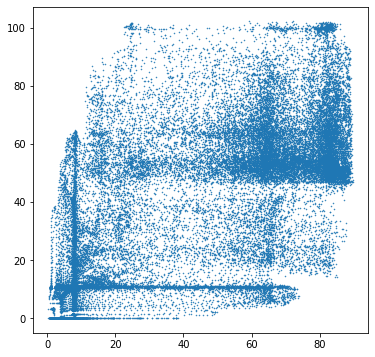

In [12]:
fig = plt.figure(figsize=(6,6))
plt.plot(t1_slice.ravel(),t2_slice_moved.ravel(),'.', markersize=1)

In [13]:
hist_2d_moved,_,_ = np.histogram2d(t1_slice.ravel(), 
                                   t2_slice_moved.ravel(), bins=50)

In [14]:
print('MI (T1 vs T2; T2 shifted):',mutual_information(hist_2d_moved))

MI (T1 vs T2; T2 shifted): 0.5347772207300899
